In [3]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.misc
import os
%matplotlib inline


import cv2

In [4]:
import pdb
from time import sleep

import tensorflow.python.platform
from tensorflow.python.platform import gfile

In [6]:
env = gym.make('MsPacman-v0')

[2017-05-08 18:30:56,537] Making new env: MsPacman-v0


In [7]:
env.reset()

# nothing happens in first 100 steps of ms pacman
for i in range(100):
    s,r,d,info = env.step(env.action_space.sample()) # take a random action

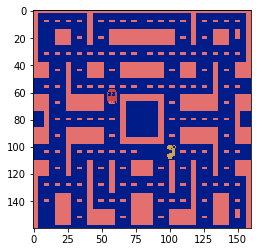

In [8]:
a = np.random.randint(0,9)

s,r,d,info = env.step(a)

a = np.random.randint(0,9)

s1,r,d,info = env.step(a)

a = np.random.randint(0,9)

s2,r,d,info = env.step(a)

plt.imshow(s1[:160,:])

frame_diff = s1[:160,:]-s[:160,:]
frame_diff_2 = s2[:160,:]-s1[:160,:]

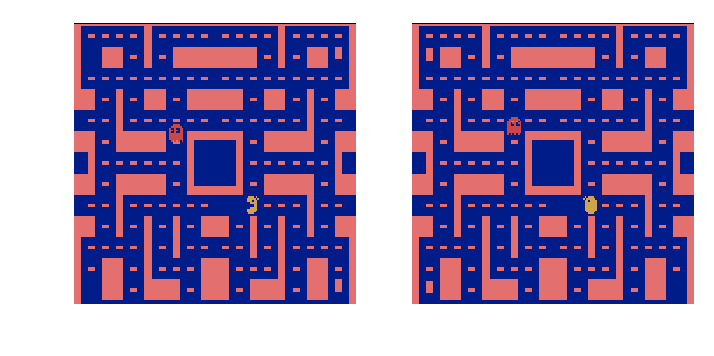

2
88.0


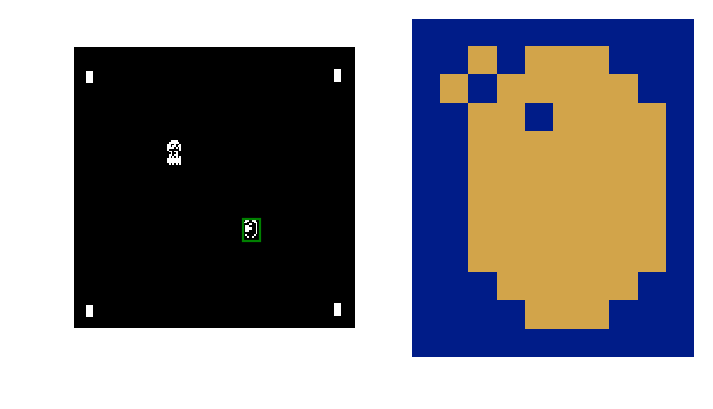

3
125.5


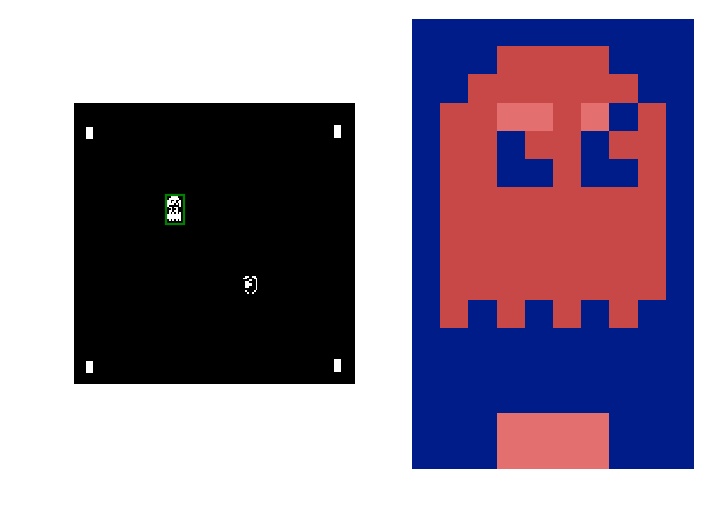

In [9]:


test=cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(test,1,255,cv2.THRESH_BINARY)[1]
thresh_dilated = cv2.dilate(thresh,None,iterations=1)
(cnts, _) = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
thresh = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)

fig = plt.figure(figsize=(5,5),dpi=160)
fig.add_subplot(121)
plt.axis('off')
plt.imshow(s1[:160,:])
fig.add_subplot(122)
plt.imshow(s[:160,:])
plt.axis('off')
plt.show()

objects = []

for i, c in enumerate(cnts):
    if cv2.contourArea(c) > 41:
        (x, y, w, h) = cv2.boundingRect(c)
        fig = plt.figure(figsize=(5,5),dpi=160)
        ax = fig.add_subplot(121)
        plt.axis('off')
        #plt.imshow(thresh[y:y+h,x:x+w])
        plt.imshow(thresh)
        print i
        print cv2.contourArea(c)
        plt.axis([1, 160, 160, 1])
        ax.add_patch(patches.Rectangle((x,y),w,h,color='g',fill=False))
        ax = fig.add_subplot(122)
        plt.axis('off')
        plt.imshow(s[y:y+h,x:x+w])
        objects.append(s[y:y+h,x:x+w])
        plt.show()

(-0.5, 9.5, 15.5, -0.5)

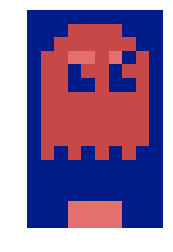

In [10]:
plt.imshow(s[y:y+h,x:x+w])
plt.axis('off')

In [11]:
class DynNetwork():
    def __init__(self):
        #self.scalarInputFrame0 =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        #self.imageInFrame0 = tf.reshape(self.scalarInputFrame0,shape=[-1,84,84,3])

        #self.scalarInputFrame1 =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        #self.imageInFrame1 = tf.reshape(self.scalarInputFrame1,shape=[-1,84,84,3])
        
        self.imageInFrame0 = tf.placeholder(shape=[1,160,160,3],dtype=tf.float32,name='imageInFrame0')
        self.imageInFrame1 = tf.placeholder(shape=[1,160,160,3],dtype=tf.float32,name='imageInFrame1')

        #self.action = tf.placeholder(shape=[1],dtype=tf.int32)
        
        with tf.variable_scope('conv1') as scope:
            kernel = tf.Variable(tf.truncated_normal([4, 4, 3, 16], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[16], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.imageInFrame0, kernel, [1, 2, 2, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.imageInFrame1, kernel, [1, 2, 2, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv1_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv1_F1 = tf.nn.relu(bias_F1,name=scope.name)

        with tf.variable_scope('conv2') as scope:
            kernel = tf.Variable(tf.truncated_normal([4, 4, 16, 8], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.conv1_F0, kernel, [1, 2, 2, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.conv1_F1, kernel, [1, 2, 2, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv2_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv2_F1 = tf.nn.relu(bias_F1,name=scope.name)
        '''
        with tf.variable_scope('conv3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 8], dtype=tf.float32,\
                                               stddev=1e-1))
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)

            conv_F0 = tf.nn.conv2d(self.conv2_F0, kernel, [1, 1, 1, 1], padding='SAME')
            conv_F1 = tf.nn.conv2d(self.conv2_F1, kernel, [1, 1, 1, 1], padding='SAME')

            bias_F0 = tf.nn.bias_add(conv_F0, biases)
            bias_F1 = tf.nn.bias_add(conv_F1, biases)

            self.conv3_F0 = tf.nn.relu(bias_F0,name=scope.name)
            self.conv3_F1 = tf.nn.relu(bias_F1,name=scope.name)
        
        '''
        with tf.variable_scope('conv_diff') as scope:
            nonzero_weightsF0 = tf.Variable(tf.truncated_normal([2, 2, 8], dtype=tf.float32,\
                                                                    stddev=1e-1), name='nonzero_weightsF0')
            nonzero_weightsF1 = tf.Variable(tf.truncated_normal([2, 2, 8], dtype=tf.float32,\
                                                                    stddev=1e-1), name='nonzero_weightsF1')
            weightsF0 = tf.matrix_set_diag(tf.zeros([2,2,8,8]),nonzero_weightsF0)
            weightsF1 = tf.matrix_set_diag(tf.zeros([2,2,8,8]),nonzero_weightsF1)
            kernel = tf.concat([weightsF0,weightsF1],2)
            
            biases = tf.Variable(tf.constant(0.0, shape=[8], dtype=tf.float32),
                           trainable=True)
            conv2_both = tf.concat([self.conv2_F0, self.conv2_F1],3)
            
            conv = tf.nn.conv2d(conv2_both, kernel, [1, 2, 2, 1], padding='SAME')
            
            bias = tf.nn.bias_add(conv, biases)
            self.conv_diff = tf.nn.relu(bias, name=scope.name)
        
        #self.cdf = slim.flatten(self.conv_diff)
        #self.fc = slim.fully_connected(self.cdf, 3)
        #self.logits = tf.concat([self.fc, [[1]]],1)
        
        self.movers_mask = tf.placeholder(shape=[1,160,160,1],dtype=tf.float32)
        #self.frame_diff_scalar = tf.reshape(self.frame_diff,[1,21168])
        
        nonzero_weightsOut = tf.Variable(tf.truncated_normal([8,8,8,1], dtype=tf.float32,\
                                                                stddev=1e-1), name='nonzero_weightsOut')

        biases = tf.Variable(tf.constant(0.0, shape=[1,160,160,1], dtype=tf.float32),
                           trainable=True)
        
        weightsProd = tf.tensordot(self.conv_diff, nonzero_weightsOut, [[3],[0]])

        
        channels = tf.unstack(weightsProd,axis=5)
        screen_channels = []
        for ch in channels:
            full_cols=[tf.reshape(t,[160,8]) for t in tf.unstack(ch,axis=1)]
            screen_channels.append(tf.concat(full_cols,1))
        weightsProd_screen = tf.stack(screen_channels,axis=2)
        
        bias = tf.add(weightsProd_screen, biases)
            
        self.out = tf.nn.relu(bias, name=scope.name)

        #self.loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.action, logits=self.logits))
        
        self.loss = tf.reduce_sum(tf.square(self.movers_mask - self.out))
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.update_model = self.trainer.minimize(self.loss)
        

In [12]:
def find_movers(s,s1):
    movers = []
    frame_diff = s1 - s
    fd_grey = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(fd_grey,1,255,cv2.THRESH_BINARY)[1]
    thresh_dilated = cv2.dilate(thresh,None,iterations=1)
    (cnts, _) = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for i, c in enumerate(cnts):
        if cv2.contourArea(c) > 41:
            (x, y, w, h) = cv2.boundingRect(c)
            movers.append((y, y+h, x, x+w))
    return movers

def movers_mask(s, s1, shape):
    movers = find_movers(s, s1)
    mask = np.zeros(shape)
    for m in movers:
        mask[m[0]:m[1], m[2]:m[3]] = 1
    return mask

In [13]:
sess = tf.Session()

net = DynNetwork()

sess.run(tf.variables_initializer(tf.global_variables()))

0
2299.43


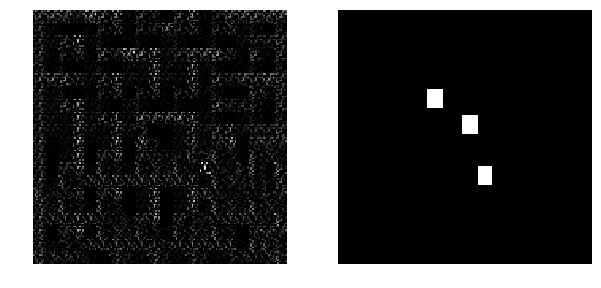

> <ipython-input-14-5711bd68deb1>(46)<module>()
-> s = s1
(Pdb) q


BdbQuit: 

In [14]:
num_steps = 50000

env.reset()

# nothing happens in first 100 steps of ms pacman
for i in range(100):
    s,r,d,info = env.step(env.action_space.sample()) # take a random action

losses = []

for i in range(num_steps):
    
    if info['ale.lives'] == 0:
        s = env.reset()
        for i in range(100):
            s,r,d,info = env.step(env.action_space.sample()) # take a random action

    a = np.random.randint(0,9)
    s1,r,d,info = env.step(a)

    s = s[:160,:]
    s1 = s1[:160,:]
    
    mask = np.expand_dims(movers_mask(s, s1, s.shape[:2]),2)
    [dummy, loss] = sess.run([net.update_model, net.loss], \
                             feed_dict={net.imageInFrame0:[s],\
                                        net.imageInFrame1:[s1],\
                                        net.movers_mask: [mask]})
    losses.append(loss)

    if i % 500 == 0:
        print i
        print losses[i]
        
        out = sess.run(tf.reshape(net.out,[160,160,1]), \
                             feed_dict={net.imageInFrame0:[s],\
                                        net.imageInFrame1:[s1],\
                                        net.movers_mask: [mask]})
        out_im = np.reshape(out,s.shape[:2])
        mask_im = np.reshape(mask,s.shape[:2])
        plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.axis('off')
        plt.imshow(out_im,cmap='gray')
        plt.subplot(122)
        plt.axis('off')
        plt.imshow(mask_im,cmap='gray')
        
        plt.show()
        pdb.set_trace()
        
    s = s1
    

In [15]:
sess.close()

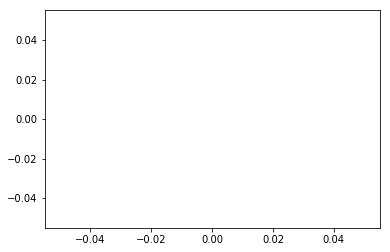

In [16]:
plt.plot(losses[100:],'o')